In [134]:
import os

In [135]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [136]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import plotly.express as px
from plotly.offline import init_notebook_mode
import seaborn as sns

In [137]:
init_notebook_mode(connected=True)

In [138]:
spy = pd.read_csv(os.path.join(os.getcwd(), '../datasets/spy.csv'))
qqq = pd.read_csv(os.path.join(os.getcwd(), '../datasets/qqq.csv'))
tqqq = pd.read_csv(os.path.join(os.getcwd(), '../datasets/tqqq.csv'))
upro = pd.read_csv(os.path.join(os.getcwd(), '../datasets/upro.csv'))

In [139]:
### We will use closing price (instead of adjusted close) as we are concerned with short term returns

In [140]:
spy = spy.loc[:, ['Date', 'Close']].rename({'Close': 'SPY'}, axis=1)
upro = upro.loc[:, ['Date', 'Close']].rename({'Close': 'UPRO'}, axis=1)
spy_df = pd.merge(spy, upro, on=['Date'], how='inner')

In [141]:
spy_df.head()

,Date,SPY,UPRO
0,2009-06-25,92.080002,2.411111
1,2009-06-26,91.839996,2.398611
2,2009-06-29,92.699997,2.466667
3,2009-06-30,91.949997,2.407778
4,2009-07-01,92.330002,2.433611


In [142]:
spy_df['Date'] = pd.to_datetime(spy_df['Date'])

In [143]:
window = 252

In [144]:
spy_df['SPY_ret'] = spy_df['SPY'].pct_change(window)

In [145]:
spy_df['UPRO_ret'] = spy_df['UPRO'].pct_change(window)

In [174]:
# px.line(pd.melt(spy_df, 
#                 id_vars=['Date'], 
#                 value_vars=['SPY_ret', 'UPRO_ret']).dropna(how='any'),
#                 x='Date', 
#                 y='value', 
#                 color='variable',
#                 title = f'Rolling SPY VS UPRO {window}-day return'
#        )

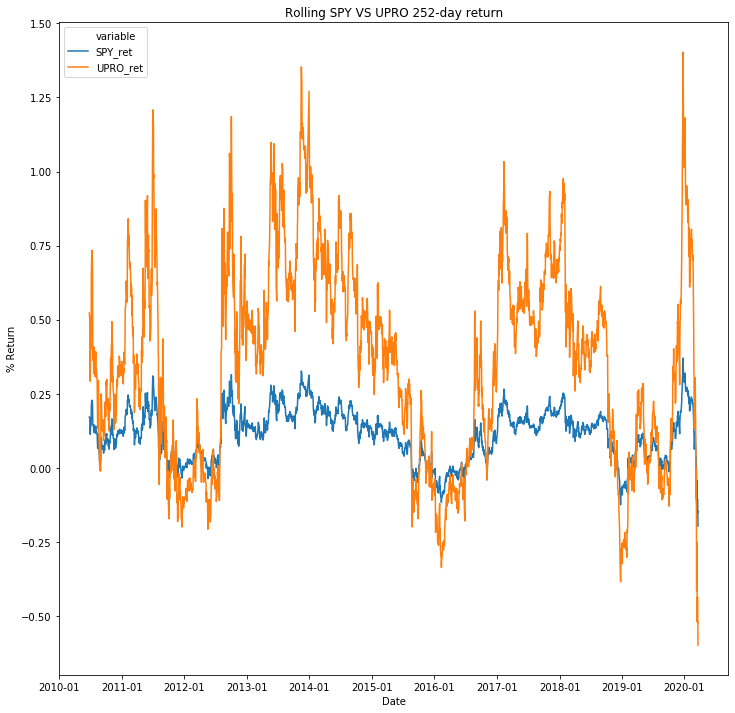

In [147]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(spy_df, 
                id_vars=['Date'], 
                value_vars=['SPY_ret', 'UPRO_ret']).dropna(how='any'));

ax.set(xlabel="Date",
       ylabel="% Return",
       title=f'Rolling SPY VS UPRO {window}-day return')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

plt.show()

In [148]:
spy_df['ret_diff'] = spy_df['UPRO_ret']/3 - spy_df['SPY_ret']

In [149]:
# px.line(spy_df, 
#         x='Date', 
#         y='ret_diff', 
#         title = f'Rolling {window}-day return diff (UPRO return divided by 3)'
#        )

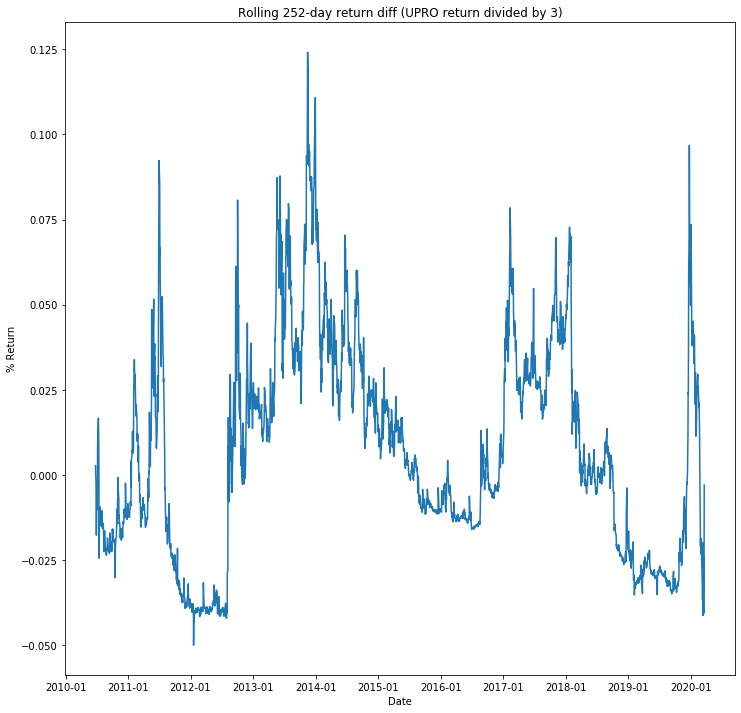

In [150]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='ret_diff', data=spy_df.dropna(how='any'));

ax.set(xlabel="Date",
       ylabel="% Return",
       title=f'Rolling {window}-day return diff (UPRO return divided by 3)')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

plt.show()

In [151]:
spy_df['vol'] = spy_df['SPY'].pct_change().rolling(window).std()*(252**0.5)

In [152]:
# px.line(pd.melt(spy_df, 
#                 id_vars=['Date'], 
#                 value_vars=['ret_diff', 'vol']),
#                 x='Date', 
#                 y='value', 
#                 color='variable',
#                 title = f'Rolling {window}-day return difference VS volatility'
#        )

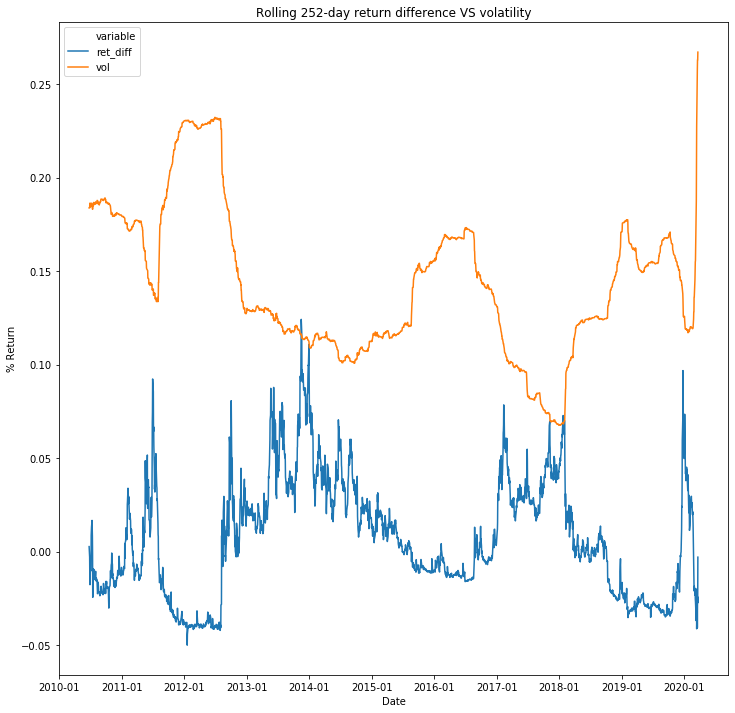

In [153]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(spy_df, 
                id_vars=['Date'], 
                value_vars=['ret_diff', 'vol']).dropna(how='any'));

ax.set(xlabel="Date",
       ylabel="% Return",
       title=f'Rolling {window}-day return difference VS volatility')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

plt.show()

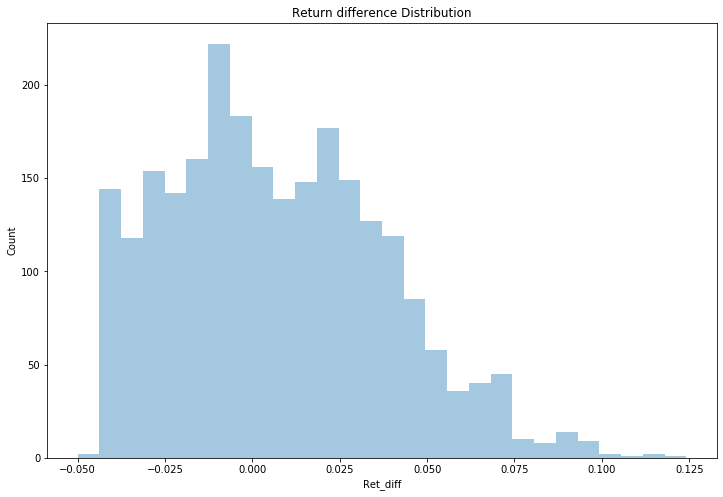

In [154]:
### Short Left Tail
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df['ret_diff'].dropna(how='any'), kde=False);

ax.set(xlabel="Ret_diff",
       ylabel="Count",
       title=f'Return difference Distribution');
plt.show()

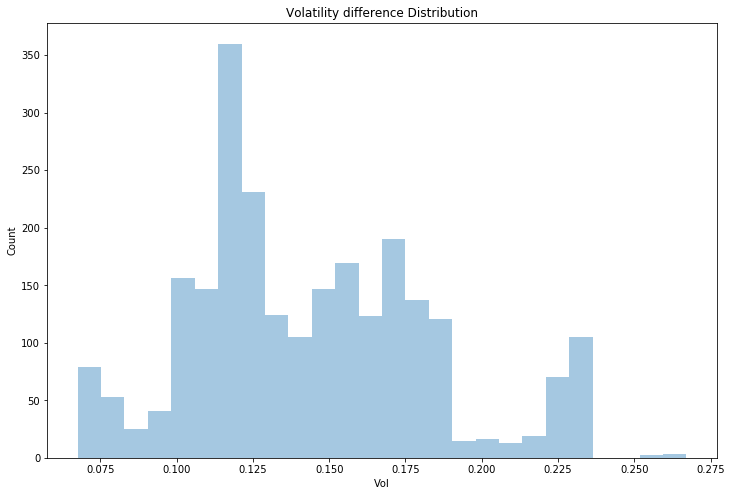

In [155]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df['vol'].dropna(how='any'),kde=False);

ax.set(xlabel="Vol",
       ylabel="Count",
       title=f'Volatility difference Distribution');
plt.show()

In [156]:
### Ideally we would want to convert the current distribution to resemble more of the normal distribution but the return looks decent enough

In [157]:
# px.line(pd.melt(spy_df, 
#                 id_vars=['Date'], 
#                 value_vars=['ret_diff', 'vol']),
#                 x='Date', 
#                 y='value', 
#                 color='variable',
#                 title = f'Rolling {window}-day return difference VS volatility standardized'
#        )

In [158]:
# Standardize for comparison
spy_df.loc[:, 'ret_diff'] = (spy_df.loc[:,  'ret_diff'] - spy_df.loc[:,  'ret_diff'].mean())/spy_df.loc[:, 'ret_diff'].std()
spy_df.loc[:, 'vol'] = (spy_df.loc[:,  'vol'] - spy_df.loc[:,  'vol'].mean())/spy_df.loc[:, 'vol'].std()

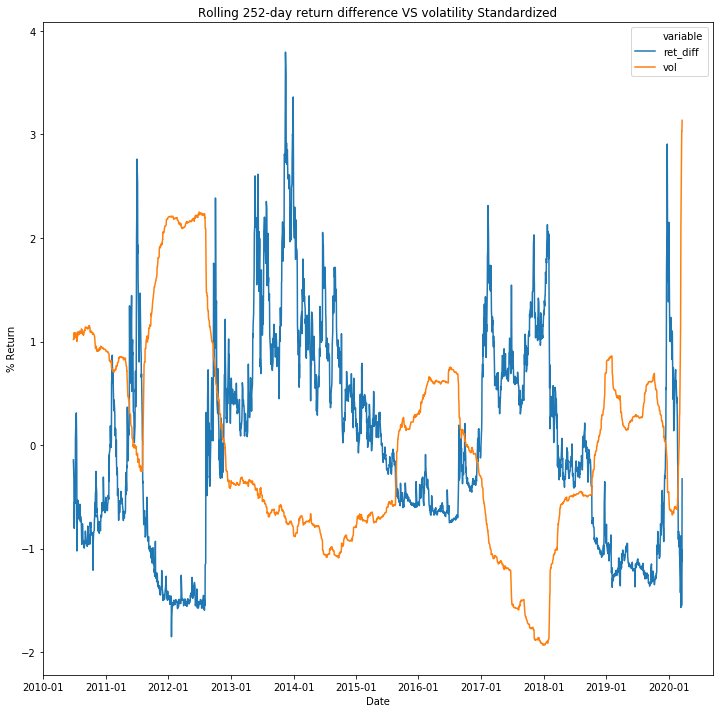

In [159]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(spy_df, 
                id_vars=['Date'], 
                value_vars=['ret_diff', 'vol']).dropna(how='any'));

ax.set(xlabel="Date",
       ylabel="% Return",
       title=f'Rolling {window}-day return difference VS volatility Standardized')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

plt.show()

In [160]:
# Highly Negatively Correlated
spy_df[['vol', 'ret_diff']].corr()

,vol,ret_diff
vol,1.000000,-0.746797
ret_diff,-0.746797,1.000000


In [161]:
OLS(spy_df['ret_diff'].dropna(how='any'), sm.add_constant(spy_df['vol'].dropna(how='any'))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ret_diff   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     3088.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:41:02   Log-Likelihood:                -2477.6
No. Observations:                2451   AIC:                             4959.
Df Residuals:                    2449   BIC:                             4971.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.637e-16      0.013  -1.22e-14      1.000      -0.026       0.026
vol           -0.7468      0.013    -55.570      0.000      -0.773      -0.720
==============================================================================
Omnibus:                      509.982   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.398
Skew:                           1.213   Prob(JB):                    8.11e-229
Kurtosis:                       5.098   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
### Significant less outperformance when volatility is above average
# px.histogram(spy_df.loc[spy_df['vol'] > 0, :], x='ret_diff', title='Return difference when Volatility above average')

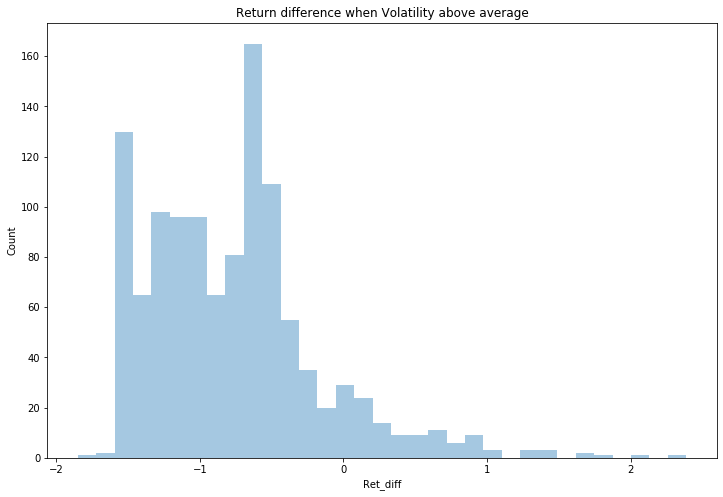

In [163]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df.loc[spy_df['vol'] > 0, 'ret_diff'], kde=False);

ax.set(xlabel="Ret_diff",
       ylabel="Count",
       title=f'Return difference when Volatility above average');
plt.show()

In [164]:
# Mean and Std when Volatility is High
spy_df.loc[spy_df['vol'] > 0, 'ret_diff'].mean(), spy_df.loc[spy_df['vol'] > 0, 'ret_diff'].std()

(-0.7685283783101939, 0.593144018306228)

In [165]:
### Significant more outperformance when Volatility is Below Average
# px.histogram(spy_df.loc[spy_df['vol'] < 0, :], x='ret_diff', title='Return difference when Volatility below average')

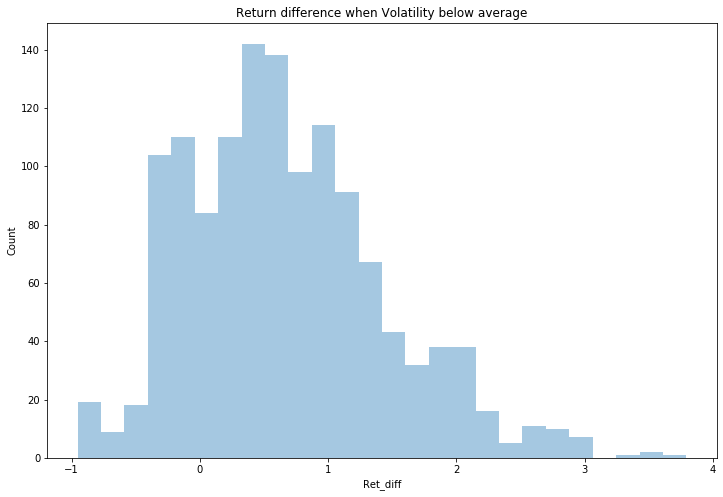

In [166]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df.loc[spy_df['vol'] < 0, 'ret_diff'], kde=False);

ax.set(xlabel="Ret_diff",
       ylabel="Count",
       title=f'Return difference when Volatility below average');
plt.show()

In [167]:
# Mean and Std when Volatility is Low
spy_df.loc[spy_df['vol'] < 0, 'ret_diff'].mean(), spy_df.loc[spy_df['vol'] < 0, 'ret_diff'].std()

(0.6715809911380366, 0.7740974242149213)

In [168]:
### Significant less outperformance when volatility is above average
# px.histogram(spy_df.loc[spy_df['vol'] > 1, :], x='ret_diff', title='Return difference when Volatility 1 Std Above Average')

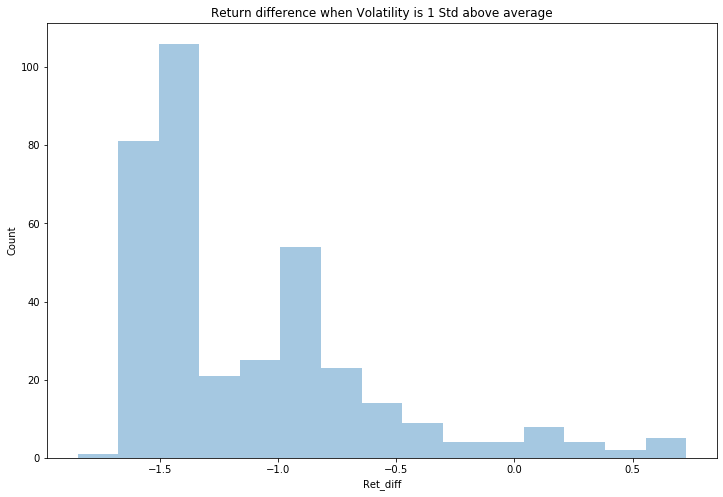

In [169]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df.loc[spy_df['vol'] > 1, 'ret_diff'], kde=False);

ax.set(xlabel="Ret_diff",
       ylabel="Count",
       title=f'Return difference when Volatility is 1 Std above average');
plt.show()

In [170]:
# Mean and Std when Volatility is Very Low
spy_df.loc[spy_df['vol'] > 1, 'ret_diff'].mean(), spy_df.loc[spy_df['vol'] > 1, 'ret_diff'].std()

(-1.1222862146073915, 0.5049817998145165)

In [171]:
# px.histogram(spy_df.loc[spy_df['vol'] < -1, :], x='ret_diff', title='Return difference when Volatility 1 Std Below Average')

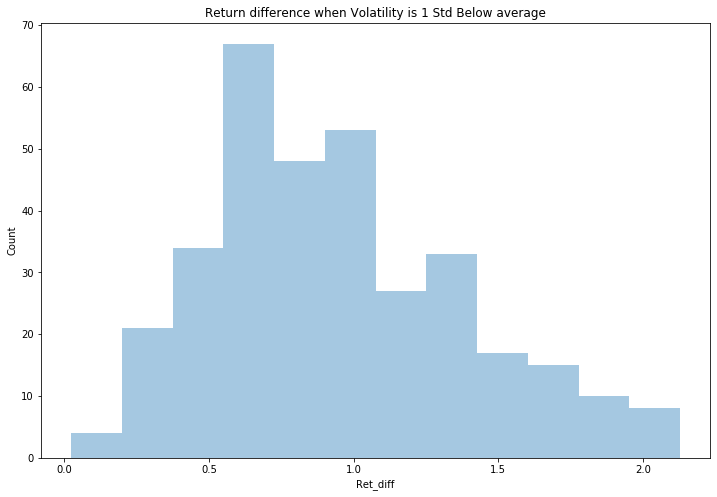

In [172]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.distplot(spy_df.loc[spy_df['vol'] < -1, 'ret_diff'], kde=False);

ax.set(xlabel="Ret_diff",
       ylabel="Count",
       title=f'Return difference when Volatility is 1 Std Below average');
plt.show()

In [173]:
# Mean and Std when Volatility is Very Low
spy_df.loc[spy_df['vol'] <-1, 'ret_diff'].mean(), spy_df.loc[spy_df['vol'] <-1, 'ret_diff'].std()

(0.938557500517563, 0.43589128188711995)